In [1]:
import numpy as np
import dataIO
from sklearn import cross_validation, linear_model, preprocessing, svm
from sklearn.grid_search import GridSearchCV
reload(dataIO)

postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr
                
userId = 8
keys = postures.keys()
locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

posture = 0
for key in keys:
    filenos = postures[key]
    if key == "two_hand":
        a, b, c, d, e, f = dataIO.process_twohand(userId, posture)
        posture += 2
    else:
        a, b, c, d, e, f = dataIO.process_posture(userId, filenos, posture)
        posture += 1
    
    locations += a
    bod += b
    targets_x += c 
    targets_y += d 
    y += e
    touch_centers += f

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x without model: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y without model: %.2f"  % np.mean(targets_y ** 2))
within_before = dataIO.circle_button_error(locations, touch_centers)

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    print
    print ("##### Fold %d #####"%foldno)
    print
    
    points_train, points_test = locations[train_index], locations[test_index]
    bod_train, bod_test = bod[train_index], bod[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    scaler = preprocessing.StandardScaler().fit(bod_train)  
    bod_scaled = scaler.transform(bod_train)
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [10, 1, 0.1 ,1e-2, 1e-3],
                         'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]
    
    clf = GridSearchCV(svm.SVC(C=1, cache_size=500), tuned_parameters)
    #clf = svm.SVC(C=100, kernel='rbf', gamma=0.01, cache_size=500)
    clf.fit(bod_scaled, y_train)
    
    print "Best hyperparameters:"
    print
    print clf.best_estimator_
    
    regr_x = []
    regr_y = []
    
    for i in range(0,5):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = np.zeros((len(points_test), 2))
    for i in range(len(points_test)):
        
        point = points_test[i]
        bod_data = scaler.transform(bod_test[i])
        pred = clf.predict(bod_data)
        
        pred_x = regr_x[pred].predict(point)
        pred_y = regr_y[pred].predict(point)
        
        new_points[i][0] = point[0]+pred_x
        new_points[i][1] = point[1]+pred_y
         
    within_after.append(dataIO.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)
    
    foldno +=1    

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("MSE on x with model: %.2f" % np.mean(se_x))
print("MSE on y with model: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)
    

MSE on x before regression: 305.11
MSE on y before regression: 128.41

##### Fold 1 #####

Best hyperparamters:

SVC(C=100, cache_size=500, class_weight=None, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Fold 2 #####

Best hyperparamters:

SVC(C=10, cache_size=500, class_weight=None, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Fold 3 #####

Best hyperparamters:

SVC(C=10, cache_size=500, class_weight=None, coef0=0.0, degree=3, gamma=0.001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

##### Fold 4 #####

Best hyperparamters:

SVC(C=0.1, cache_size=500, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=Fals

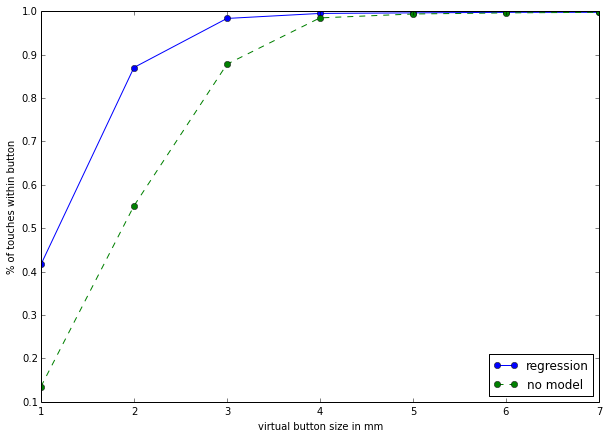

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,8), within_after, marker="o", label = "model")
plt.errorbar(range(1,8), within_before, linestyle="--", marker="o", label="no model")

plt.legend(loc='lower right')
plt.xlabel('virtual button size in mm')
plt.ylabel('% of touches within button')
plt.show()

#plt.savefig("predictpostures.png")